In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns
import pandas as pd
import h5py

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import scipy.ndimage
import scipy.stats

import sleap 
sleap.versions()

SLEAP: 1.3.0
TensorFlow: 2.6.5
Numpy: 1.19.5
Python: 3.7.12
OS: Linux-5.4.0-139-generic-x86_64-with-debian-bookworm-sid


# Preprocessing

In [2]:
shark_slp_files = """
data/shark.video_1.slp
data/shark.video_2.slp
data/shark.video_3.slp
data/shark.video_4.slp
""".strip().split()

remora_slp_files = """
data/remora.video_1.slp
data/remora.video_2.slp
data/remora.video_3.slp
data/remora.video_4.slp
""".strip().split()


def load_tracks(slp_file):
    labels = sleap.load_file(slp_file)
    n_frames = len(labels.video)
    n_nodes = len(labels.skeleton)
    n_tracks = max(len(labels.tracks), 1)
    is_single_instance = n_tracks <= 1

    tracks = np.full((n_frames, n_tracks, n_nodes, 2), np.nan)
    for lf in labels:
        frame_ind = lf.frame_idx
        for inst in lf:
            if inst.track is None:
                if is_single_instance:
                    track_ind = 0
                else:
                    continue
            else:
                track_ind = labels.tracks.index(inst.track)

            tracks[frame_ind, track_ind] = inst.numpy()
    
    return tracks


remora_tracks = [load_tracks(p) for p in remora_slp_files]
remora_skeleton = sleap.load_file(remora_slp_files[0]).skeleton
remora_nodes = remora_skeleton.node_names
# remora_tracks[2] = remora_tracks[2][:, :5]  # crop extraneous/short tracks in video_3


shark_tracks = [load_tracks(p).squeeze() for p in shark_slp_files]
shark_skeleton = sleap.load_file(shark_slp_files[0]).skeleton
shark_nodes = shark_skeleton.node_names

print("Remora:", remora_nodes)
print("Shark:", shark_nodes)

print(f'remora tracks of shape: {[x.shape for x in remora_tracks]}')
print(f'shark tracks of shape: {[x.shape for x in shark_tracks]}')

Remora: ['head', 'f_dorsal', 'r_dorsal']
Shark: ['mouth', 'l_mouth', 'l_head', 'r_mouth', 'r_head']
remora tracks of shape: [(763, 3, 3, 2), (275, 4, 3, 2), (568, 10, 3, 2), (602, 5, 3, 2)]
shark tracks of shape: [(763, 5, 2), (275, 5, 2), (568, 5, 2), (602, 5, 2)]


# Analysis

In [3]:
def fill_missing(x, kind="nearest", limit_direction="both", limit_area="inside", limit=5, **kwargs):
    """Fill missing values in a timeseries.
    
    Args:
        x: Timeseries of shape (time, ...).
        kind: Type of interpolation to use. Defaults to "nearest".
    
    Returns:
        Timeseries of the same shape as the input with NaNs filled in.
    
    Notes:
        This uses pandas.DataFrame.interpolate and accepts the same kwargs.
    """
    return pd.DataFrame(x.reshape(len(x), -1)).interpolate(kind=kind, axis=0, limit_direction=limit_direction, limit_area=limit_area, limit=limit, **kwargs).to_numpy().reshape(x.shape)


def smooth_diff(node_loc, win=25, poly=3, order=0):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=order)
    
    # node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_loc_vel


def connected_components1d(x, return_limits=False):
    """Return the indices of the connected components in a 1D logical array.
    
    Args:
        x: 1d logical (boolean) array.
        return_limits: If True, return indices of the limits of each component rather
            than every index. Defaults to False.
            
    Returns:
        If return_limits is False, a list of (variable size) arrays are returned, where
        each array contains the indices of each connected component.
        
        If return_limits is True, a single array of size (n, 2) is returned where the
        columns contain the indices of the starts and ends of each component.
    """
    L, n = scipy.ndimage.label(x.squeeze())
    ccs = scipy.ndimage.find_objects(L)
    starts = [cc[0].start for cc in ccs]
    ends = [cc[0].stop for cc in ccs]
    if return_limits:
        return np.stack([starts, ends], axis=1)
    else:
        return [np.arange(i0, i1, dtype=int) for i0, i1 in zip(starts, ends)]
    
    
def lims_to_mask(lims, size=None):
    """Convert limits to a mask.
    
    Args:
        lims: Indices of limits as an array of shape (n, 2).
        size: Number of elements in the vector. If not provided, uses the largest limit.
    
    Returns:
        A logical vector of shape (size,) where elements whose indices are contained in
        the input lims are True.
    """
    if not isinstance(lims, np.ndarray):
        lims = np.array(lims)
    lims = lims.astype(int)
    if size is None:
        size = lims.max()
    mask = np.full((size,), False)
    for i0, i1 in lims:
        mask[i0:i1] = True
    return mask

In [4]:
video_ind = 2

raw_trx = remora_tracks[video_ind]
trx = np.copy(raw_trx)
trx = fill_missing(trx, kind="linear", limit=10, limit_area=None)
vel = np.linalg.norm(smooth_diff(trx.reshape(len(trx), -1), order=1).reshape(trx.shape), axis=-1)
trx = smooth_diff(trx.reshape(len(trx), -1), order=0).reshape(trx.shape)

ctr = np.nanmedian(trx, axis=2)
ctr_vel = np.linalg.norm(smooth_diff(ctr.reshape(len(ctr), -1), order=1).reshape(ctr.shape), axis=-1)

trx.shape, vel.shape, ctr.shape, ctr_vel.shape

/opt/conda/envs/python37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


((568, 10, 3, 2), (568, 10, 3), (568, 10, 2), (568, 10))

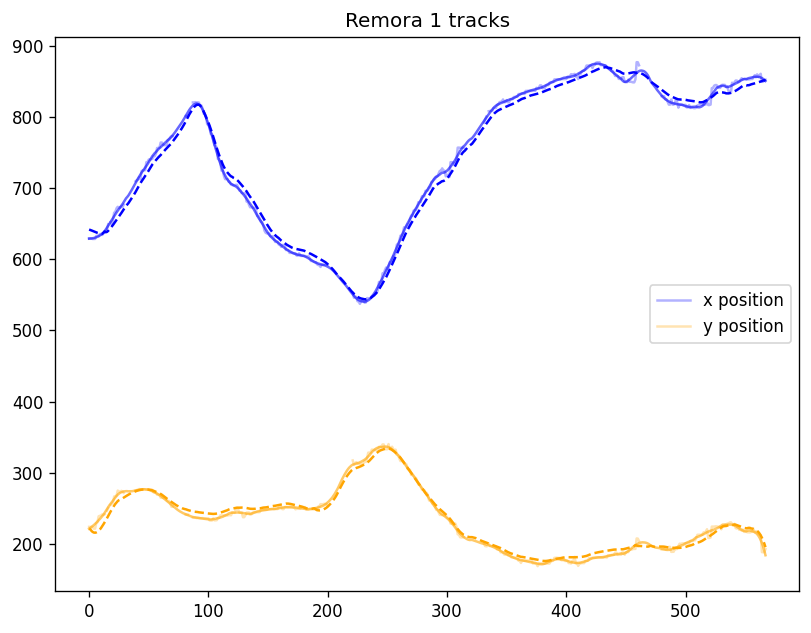

In [5]:
fig = plt.figure(figsize=(8,6), dpi=120, frameon=False, facecolor='w')
plt.plot(trx[:,0,0,0], color='blue', alpha=0.6)
plt.plot(trx[:,0,0,1], color='orange', alpha=0.6)
plt.plot(raw_trx[:,0,0,0], label='x position', color='blue', alpha=0.3)
plt.plot(raw_trx[:,0,0,1], label='y position', color='orange', alpha=0.3)
plt.plot(ctr[:,0,0], '--',color='blue')
plt.plot(ctr[:,0,1],'--', color='orange')
plt.title('Remora 1 tracks')
plt.legend();
plt.savefig('figs/raw_track.png', format='png', dpi='figure')
#plt.plot(trx[:,0,0,0])

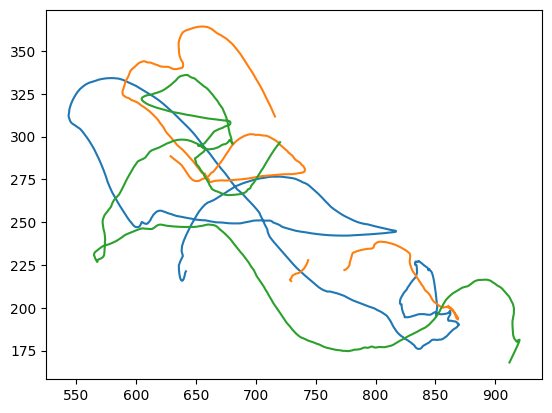

In [6]:
plt.plot(ctr[:,0,0], ctr[:,0,1])
plt.plot(ctr[:,1,0], ctr[:,1,1])
plt.plot(ctr[:,2,0], ctr[:,2,1])

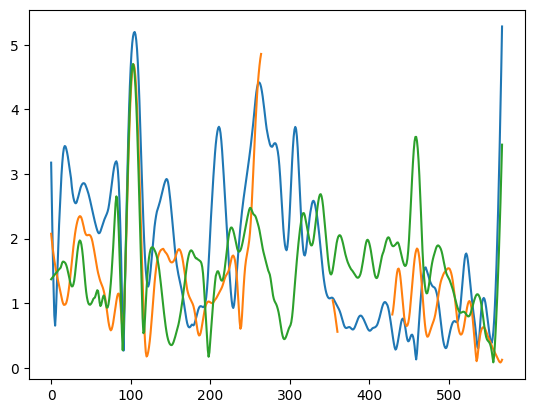

In [7]:
plt.plot(ctr_vel[:, 0])
plt.plot(ctr_vel[:, 1])
plt.plot(ctr_vel[:, 2])

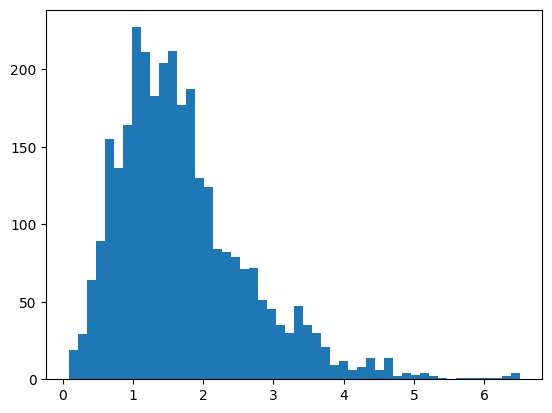

In [8]:
plt.hist(ctr_vel.flatten(), bins=50);

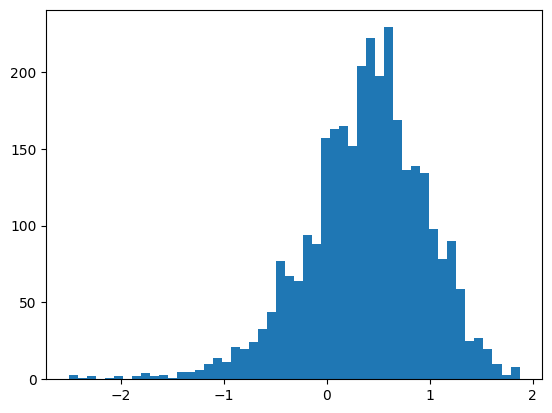

In [9]:
plt.hist(np.log(ctr_vel.flatten()), bins=50);

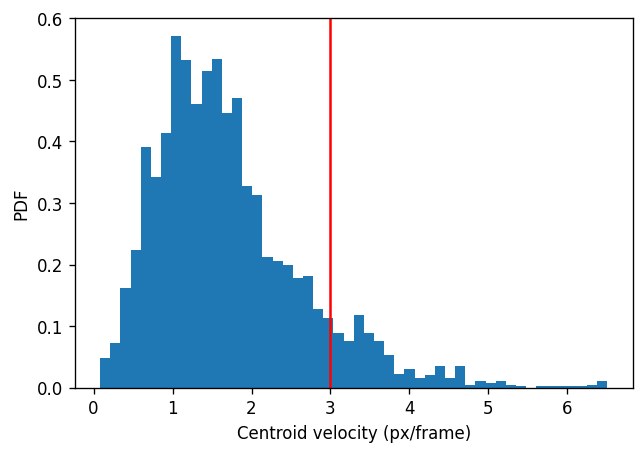

In [10]:
plt.figure(figsize=(6, 4), dpi=120, facecolor="w")
plt.hist(ctr_vel.flatten(), bins=50, density=True);
plt.axvline(x=3, c="r")
plt.xlabel("Centroid velocity (px/frame)"), plt.ylabel("PDF");
plt.savefig('figs/vid_2_vel_hist.png', format='png', dpi='figure')

In [11]:
burst_threshold = 3  # px/frame
is_bursting = ctr_vel >= burst_threshold

bursts = [connected_components1d(x, return_limits=True) for x in is_bursting.T]
bursts

[array([[  0,   1],
        [ 14,  25],
        [ 78,  85],
        [ 96, 114],
        [205, 217],
        [247, 288],
        [303, 312],
        [564, 568]]),
 array([[ 97, 111],
        [255, 265]]),
 array([[ 97, 110],
        [455, 463],
        [567, 568]]),
 array([[ 98, 111],
        [264, 286]]),
 array([[ 94, 118],
        [257, 284]]),
 array([[ 13,  30],
        [ 49,  56],
        [ 68,  75],
        [101, 110],
        [125, 149],
        [485, 490]]),
 array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64)]

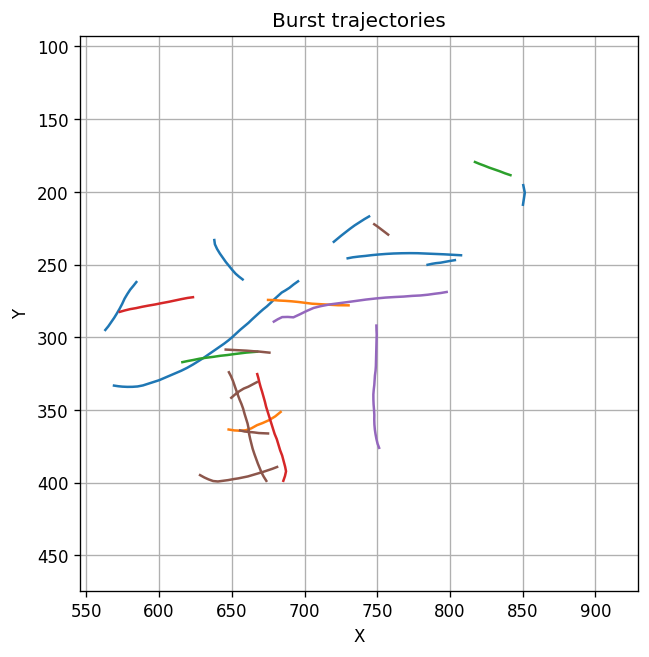

In [12]:
plt.figure(figsize=(6, 6), dpi=120, facecolor="w")

for animal, burst_animal in enumerate(bursts):
    ctr_animal = ctr[:, animal]
    mask = lims_to_mask(burst_animal, size=len(ctr_animal))
    pts = ctr_animal.copy()
    pts[~mask] = np.nan
    plt.plot(pts[:, 0], pts[:, 1])
    # plt.plot(pts[0, 0], pts[0, 1], "gx")
    # plt.plot(pts[-1, 0], pts[-1, 1], "ro")

plt.axis("equal")
plt.ylim(plt.ylim()[::-1])
plt.xlabel("X"), plt.ylabel("Y")
plt.title("Burst trajectories")
plt.grid(True);
plt.savefig('figs/vid_2_bursting.png', format='png', dpi='figure')

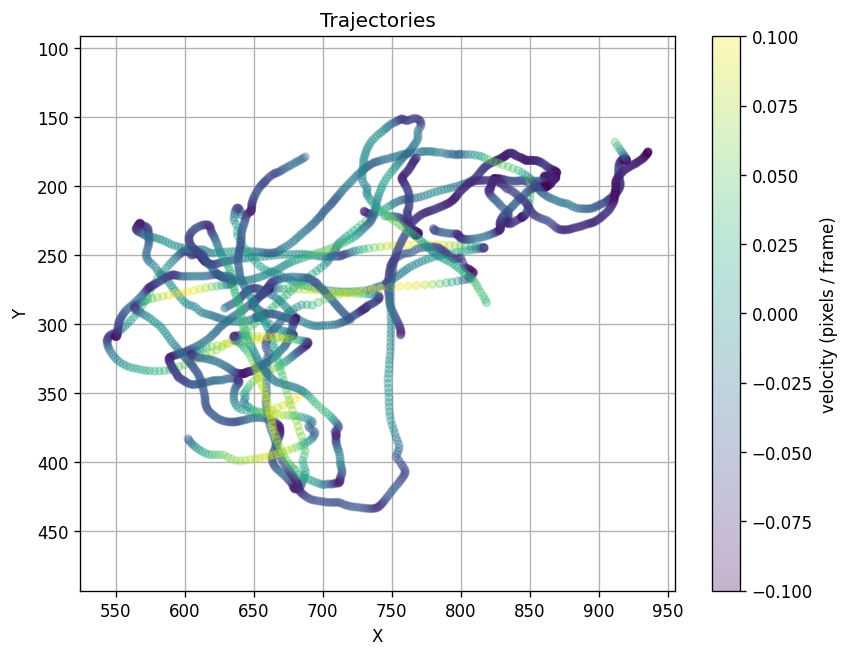

In [13]:
plt.figure(figsize=(8, 6), dpi=120, facecolor="w")

for animal in range(ctr.shape[1]):
    ctr_animal = ctr[:, animal]
    vel_animal = ctr_vel[:, animal]
    plt.scatter(ctr_animal[:, 0], ctr_animal[:, 1], c=vel_animal, alpha=0.3, s=20, zorder=100)

plt.axis("equal")
plt.ylim(plt.ylim()[::-1])
plt.xlabel("X"), plt.ylabel("Y")
plt.title("Trajectories")
plt.grid(True, zorder=-100);
plt.colorbar(location='right', label='velocity (pixels / frame)');
plt.savefig('figs/vid_2_vel_highlighted_tracks.png', format='png', dpi='figure')

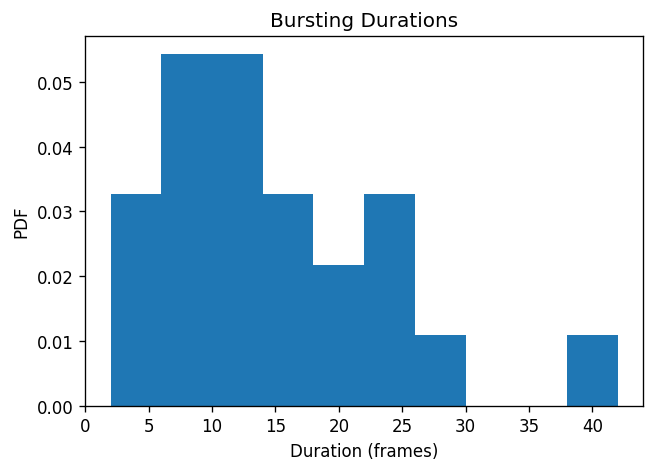

In [14]:
burst_durations = [(b[:, 1] - b[:, 0])+1 for b in bursts if len(b) > 0]

plt.figure(figsize=(6, 4), dpi=120, facecolor="w")
plt.hist(np.concatenate(burst_durations), bins=10, density=True)
plt.xlabel("Duration (frames)")
plt.ylabel("PDF")
plt.title('Bursting Durations');
plt.savefig('figs/vid_2_bursting_hist.png', format='png', dpi='figure')

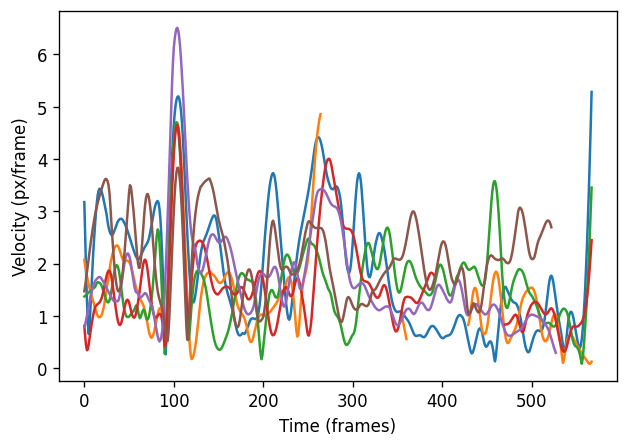

In [15]:
plt.figure(figsize=(6, 4), dpi=120, facecolor="w")
for animal in range(ctr_vel.shape[1]):
    ctr_animal = ctr_vel[:, animal]
    plt.plot(ctr_animal)
plt.xlabel("Time (frames)")
plt.ylabel("Velocity (px/frame)");

/opt/conda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.


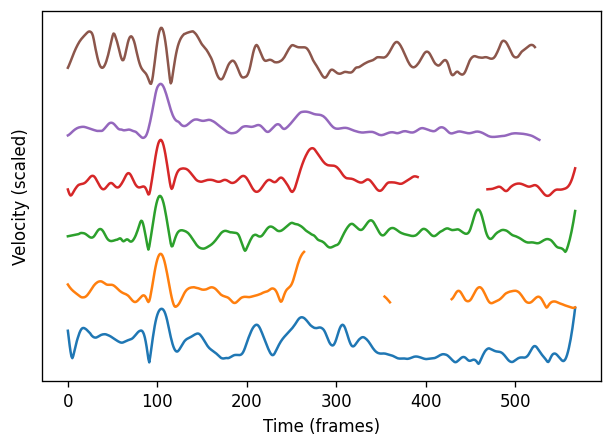

In [16]:
plt.figure(figsize=(6, 4), dpi=120, facecolor="w")
for animal in range(ctr_vel.shape[1]):
    ctr_animal = ctr_vel[:, animal]
    ctr_animal = (ctr_animal - np.nanmin(ctr_animal)) / (np.nanmax(ctr_animal) - np.nanmin(ctr_animal))
    plt.plot(ctr_animal + animal)
plt.yticks([])
plt.xlabel("Time (frames)")
plt.ylabel("Velocity (scaled)");
plt.savefig('figs/vid_2_vels.png', format='png', dpi='figure')